In [1]:
# import the necessary packages
import numpy as np
import tensorflow as tf
import datetime
import time
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from scipy.spatial import distance

In [2]:
# Pretrained classes in the model
classNames = {0: 'background',
              1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus',
              7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant',
              13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat',
              18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear',
              24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag',
              32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard',
              37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove',
              41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle',
              46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon',
              51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange',
              56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut',
              61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed',
              67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse',
              75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven',
              80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock',
              86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush'}

def id_class_name(class_id, classes):
    for key, value in classes.items():
        if class_id == key:
            return value

def scatter_plot(frame, points):
    plt.clf()
    plt.figure(1)
    plt.subplot(1,2,1, aspect='equal', adjustable='box')
    plt.imshow(frame)
    plt.axis('off')
    plt.subplot(1,2,2, aspect='equal', adjustable='box')
    plt.xlim((0, 640))
    plt.ylim((480, 0))
    plt.scatter(points[:,0], points[:,1])
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)    

# Loading model
model = cv2.dnn.readNetFromTensorflow('model/ssd_mobilenet_v2_frozen_inference_graph.pb',
                                      'model/ssd_mobilenet_v2_coco_2018_03_29.pbtxt')
#model = cv2.dnn.readNetFromTensorflow('model/ssd_mobilenet_v3_frozen_inference_graph.pb',
#                                      'model/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt')

In [3]:
# Homography Estimation
selPt = []
def click_and_select(event, x, y, flags, param):
    # grab references to the global variables
    global selPt
    # if the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being
    # performed
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(frame_concat,(x,y),5,(0,0,255),-1)
        selPt.append([x, y])
        
def grid_overlay(image):
    h, w = image.shape[:2]
    for x in range(0, w - 1, 20):
        cv2.line(image, (x, 0), (x, h), (0, 255, 0), 1, 1)

    for y in range(0, h - 1, 20):
        cv2.line(image, (0, y), (w, y), (0, 255, 0), 1, 1)
    
    return image


cap = cv2.VideoCapture('TownCentreXVID.avi')
time.sleep(0.25)

cv2.namedWindow("frame")
cv2.setMouseCallback("frame", click_and_select)

ret, frame = cap.read()
frame = cv2.resize(frame, (640, 480))
frame_width, frame_height = frame.shape[:2]
print('frame (W,H):', frame_width, frame_height)

grid = np.zeros(frame.shape, np.uint8)
frame_concat = np.concatenate((frame, grid), axis=1)


while (True):    
    cv2.imshow("frame", grid_overlay(frame_concat)) # Inital Capture 
    k = cv2.waitKey(20) & 0xFF
    if k == ord('q'):
        break
    elif k == ord('a'):
        print(selPt)

print(len(selPt))
if len(selPt) == 8: 
    selPt = np.array(selPt)
    # Locate points of the documents or object which you want to transform 
    srcPt = np.float32(np.array(selPt[:4]))
    dstPt = np.float32(np.array(selPt[4:8]))
    print(dstPt.shape)
    dstPt[:,0] = dstPt[:,0] - frame_height 
    print(dstPt[:,0])
    print(dstPt[:,1])

    # Apply Perspective Transform Algorithm 
    matrix = cv2.getPerspectiveTransform(srcPt, dstPt) 
    #result = cv2.warpPerspective(frame, matrix, (600, 600)) 
    result = cv2.warpPerspective(frame, matrix, (frame_height, frame_width))
    print('frame:', frame.shape)
    print('result:', result.shape)
    frame_warp = np.concatenate((frame, result), axis=1)
    cv2.imshow("frame warp", grid_overlay(frame_warp))
    # Wrap the transformed image
    cv2.waitKey(0) 


# cleanup the camera and close any open windows
cap.release()
cv2.destroyAllWindows()

frame (W,H): 480 640
8
(4, 2)
[232. 394. 230. 394.]
[  9.   6. 473. 469.]
frame: (480, 640, 3)
result: (480, 640, 3)


In [4]:
def project_points (points):
    points = np.array(points)
    out = []
    for x,y,w,h in points:
        loc_h = [int(x), int(h), 1]
        #print(loc)
        #loc_h = cv2.convertPointsToHomogeneous(np.array(loc))
        proj = np.matmul(matrix, loc_h)
        proj = proj / proj[2]
        out.append([int(proj[0]), int(proj[1])])
    return out

def point_overlay(image, points, project=True):
    points = np.array(points)
    sum_h = 0
    loc = []
    for x,y,w,h in points:
        #cv2.circle(image, (int(x), int(h)), 4, (255, 0, 0), thickness=8)
        loc.append([int(x), int(h)])
        sum_h += np.abs(h - y)
    num_ppl = len(points)
    avg_h = sum_h / num_ppl
    threshold = 60 #1.2 * avg_h
    loc = np.array(loc)
    dist_mat = distance.cdist(loc, loc, 'euclidean')
    if project == True:
        loc = project_points(points)
        loc = np.array(loc)
        dist_mat = distance.cdist(loc, loc, 'euclidean')
    
    for i, n in enumerate(dist_mat):
        if np.count_nonzero(n < threshold) > 1:
            x, y = loc[i, :]
            cv2.circle(image, (int(x), int(y)), 4, (0, 0, 255), thickness=8, lineType=cv2.FILLED)
        else:
            x, y = loc[i,:]
            cv2.circle(image, (int(x), int(y)), 4, (0, 255, 0), thickness=8, lineType=cv2.FILLED)
    return image

camera = cv2.VideoCapture('TownCentreXVID.avi')
time.sleep(0.25)

# initialize the first frame in the video stream
print("Press 'Q' to quit application\n")

# loop over the frames of the video
frame_count = 0
while (True):
    # grab the current frame and initialize the occupied/unoccupied
    # text
    (grabbed, frame) = camera.read()
    frame_count += 1
    start = time.time()
    frame = cv2.resize(frame, (640, 480))
    frame_width, frame_height = frame.shape[:2]
    
    # if the frame could not be grabbed, then we have reached the end
    # of the video
    if not grabbed:
        break
    
    # resize frame to (640, 480)
    model.setInput(cv2.dnn.blobFromImage(frame, size=(640, 480), swapRB=True))
    
    output = model.forward()
    count = 0
    peopleLoc = []
    for detection in output[0, 0, :, :]:
        confidence = detection[2]
        if confidence > 0.5:
            class_id = detection[1]
            class_name=id_class_name(class_id,classNames)
            if class_name == 'person':
                count += 1
                det_label = "person_{}".format(len(peopleLoc))
                #print(str(str(class_id) + " " + str(detection[2])  + " " + class_name))
                box_x = detection[3] * frame_height
                box_y = detection[4] * frame_width
                box_width = detection[5] * frame_height
                box_height = detection[6] * frame_width
                peopleLoc.append([int(box_x), int(box_y), int(box_width), int(box_height)])
                cv2.rectangle(frame, (int(box_x), int(box_y)), (int(box_width), int(box_height)), (23, 230, 210), thickness=2)
                cv2.circle(frame, (int(box_x), int(box_height)), 2, (255, 0, 0), thickness=2)
                #cv2.putText(frame,class_name ,(int(box_x), int(box_y)),cv2.FONT_HERSHEY_SIMPLEX,(.001*frame_width),(0, 0, 255))
                cv2.putText(frame,det_label ,(int(box_x), int(box_y)),cv2.FONT_HERSHEY_SIMPLEX,(.001*frame_width),(0, 0, 255))
    
    # draw the text and timestamp on the frame
    cv2.putText(frame, "People Detected : {}, Run time:{:.3f}".format(count, time.time()- start), (10, 20),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.putText(frame, datetime.datetime.now().strftime("%A %d %B %Y %I:%M:%S%p"),
                (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 2)

    # show the frame and record if the user presses a key
    grid = np.zeros(frame.shape, np.uint8)
    grid = point_overlay(grid, peopleLoc, True)
    frame_concat = np.concatenate((frame, grid), axis=1)
    cv2.imshow("Camera Feed", frame_concat)
    if frame_count <= 10:
        cv2.imwrite("output_{}.jpg".format(frame_count), frame_concat)
    key = cv2.waitKey(1) & 0xFF
    
    # if the `q` key is pressed, break from the lop
    if key == ord("q"):
        break

# cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()


Press 'Q' to quit application



In [4]:
# Estimate Transformation
# Intrinsic parameters
FocalLengthX = 2696.35888671875000000000
FocalLengthY = 2696.35888671875000000000
PrincipalPointX = 959.50000000000000000000
PrincipalPointY = 539.50000000000000000000
Skew = 0.00000000000000000000
TranslationX = -0.05988363921642303467
TranslationY = 3.83331298828125000000
TranslationZ = 12.39112186431884765625
RotationX = 0.69724917918208628720
RotationY = -0.43029624469563848566
RotationZ = 0.28876888503799524877
RotationW = 0.49527896681027261394
DistortionK1 = -0.60150605440139770508
DistortionK2 = 4.70203733444213867188
DistortionP1 = -0.00047452122089453042
DistortionP2 = -0.00782289821654558182

# Camera matrix
cameraMatrix = np.float32([[FocalLengthX,  0,  PrincipalPointX],
                           [ 0, FocalLengthY,  PrincipalPointY],
                           [ 0,            0,    1]])
#print('cameraMatrix:', cameraMatrix)

distCoeffs = np.float32([DistortionK1, DistortionK2, DistortionP1, DistortionP2])
#print('distCoeffs:', distCoeffs)
rvecs = np.float32([RotationX, RotationY, RotationZ])
#print('rvecs:', rvecs)
tvecs = np.float32([TranslationX, TranslationY, TranslationZ])

cap = cv2.VideoCapture('TownCentreXVID.avi')
time.sleep(0.25)

cv2.namedWindow("frame")

ret, frame = cap.read()
#frame = cv2.resize(frame, (640, 480))
w, h = frame.shape[:2]
print('frame (W, H):', w, h)

newcameramtx, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix,distCoeffs,(h,w),1,(h,w))
print(roi)
# undistort
mapx, mapy = cv2.initUndistortRectifyMap(cameraMatrix,distCoeffs,None,newcameramtx,(h,w),5)
dst = cv2.remap(frame,mapx,mapy,cv2.INTER_LINEAR)

cv2.imshow("frame", frame)
cv2.imshow("dst", dst)
cv2.waitKey(0)

# cleanup the camera and close any open windows
cap.release()
cv2.destroyAllWindows()


frame (W, H): 1080 1920
(22, 26, 1875, 1029)


[-12050.749      3650.977        12.391122]
[[ 3.24127381e-04  4.19014468e-05  8.06282043e-01]
 [-1.46347142e-04  2.71734345e-04  5.60660422e-01]
 [-1.05208775e-04 -2.48896889e-04  4.49702621e-01]]
[9.99088  6.948262 5.571372]
[[1.       0.       9.99088 ]
 [0.       1.       6.948262]
 [0.       0.       5.571372]]


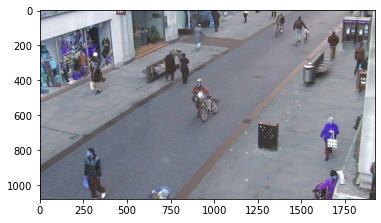

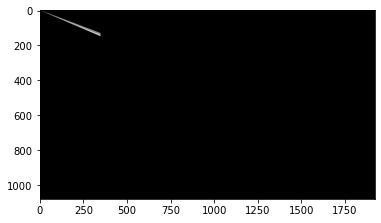

In [46]:
# Estimate transformation
# Extrensic parameters

R, _ = cv2.Rodrigues(rvecs)
T = tvecs
K = cameraMatrix
P = np.matmul(K,R)
t = np.matmul(K,T)
print(t)
Pinv = np.linalg.inv(P)
print(Pinv)
Tf = np.matmul(Pinv,T)
print(Tf)
Tf = np.float32([[1, 0, Tf[0]],
                 [0, 1, Tf[1]],
                 [0, 0, Tf[2]]])
print(Tf)
'''
#print('R:', R)
Rinv = np.linalg.inv(R)

Kinv = np.linalg.inv(K)
Hr = np.matmul(np.matmul(K, Rinv), Kinv)
C = - np.matmul(Rinv, tvecs)
#print(C)
C = -1 * (C / C[2])
#print(C)
#print('w,h:', w, h)
C_shift =  [C[0] - h, C[1] - w, C[2]]
#print(C_shift)
Ht = np.float32([[1, 0, C_shift[0]],
                 [0, 1, C_shift[1]],
                 [0, 0, C_shift[2]]])

H = np.matmul(Ht, Hr)
Ht = np.float32([[1, 0, 100],
                 [0, 1, 100],
                 [0, 0,   1]])

Hr = np.float32([[1, 0, 0],
                 [0, 1, 0],
                 [0, 0, 1]])

H = np.matmul(Ht, Hr)
print(H)
'''
'''
H = np.float32([[1, 1,    0],
                [0, 1,    0],
                [0, 0,    1]])
'''

w,h = frame.shape[:2]
result = cv2.warpPerspective(frame, Pinv, (h,w)) 
result = cv2.warpPerspective(result, Tf, (h,w)) 

plt.figure(1)
plt.imshow(frame)
plt.figure(2)
plt.imshow(result)

frame (W, H): 1080 1920
A: (4, 3)
R: (4, 4)
T: (4, 4)
K: (3, 4)
M: [[ 1.6037616e+03  1.7804761e+03  7.6052422e+04]
 [-2.1547881e+03  1.4765226e+03  2.7085998e+06]
 [ 1.3642220e-01  8.5531706e-01  2.0916272e+03]]


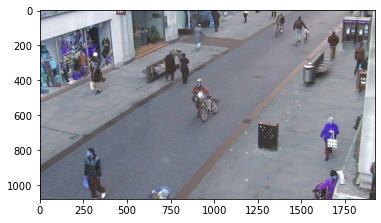

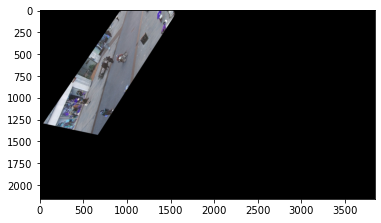

In [152]:
cap = cv2.VideoCapture('TownCentreXVID.avi')
time.sleep(0.25)

cv2.namedWindow("frame")

ret, frame = cap.read()
#frame = cv2.resize(frame, (640, 480))
w, h = frame.shape[:2]
print('frame (W, H):', w, h)

alpha = RotationX #40 * np.pi / 180
beta  = RotationY #50 * np.pi / 180
gamma = RotationZ #-50 * np.pi / 180
f = fx 
dist = fx

Px = PrincipalPointX
Py = PrincipalPointY
fx = 2696.35888671875000000000
fy = 2696.35888671875000000000

tx = TranslationX 
ty = TranslationY 
tz = TranslationZ 

# Link: https://answers.opencv.org/question/174548/inverse-perspective-mapping-ipm-on-the-capture-from-camera-feed/
# Projection Matrix
A = np.float32([[1, 0,  -Px],
                [0, 1,  -Py],
                [0, 0,    0],
                [0, 0,    1]])
print('A:', A.shape)
Rx = np.float32([[1, 0, 0, 0],
                 [0, np.cos(alpha), np.sin(alpha), 0],
                 [0, -np.sin(alpha), np.cos(alpha), 0],
                 [0, 0, 0, 1]])

Ry = np.float32([[np.cos(beta), 0, -np.sin(beta), 0],
                 [0, 1, 0, 0],
                 [np.sin(beta), 0, np.cos(beta), 0],
                 [0, 0, 0, 1]])

Rz = np.float32([[np.cos(gamma), np.sin(gamma), 0, 0],
                 [-np.sin(gamma), np.cos(gamma),  0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])
# Rotation Matrix
R = np.matmul(np.matmul(Rx,Ry),Rz)
print('R:', R.shape)
# Translation Matrix
T = np.float32([[1, 0, 0, -tx],
                [0, 1, 0, -ty],
                [0, 0, 1, -tz+fx],
                [0, 0, 0, 1]])
print('T:', T.shape)
# Intrinsic matrix
K = np.float32([[fx, 0, Px, 0],
                [0, fy, Py, 0],
                [0, 0, 1, 0]])
print('K:', K.shape)

M = np.matmul(K,np.matmul(T,np.matmul(R, A)))

print('M:', M)
#result = cv2.warpPerspective(frame, M, (h,w), flags=cv2.WARP_INVERSE_MAP)
result = cv2.warpPerspective(frame, M, (h*2,w*2))


plt.figure(1)
plt.imshow(frame)
plt.figure(2)
plt.imshow(result)
